In [1]:
#імпорт необхідних бібліотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import statistics
import numpy as np
import requests
import os

In [2]:
#створення DataFrame з датасету з використанням першої колонки як індексу
#видалення другої колонки, так як вона ідентична першій
space_data = pd.read_csv("Space_Corrected.csv", index_col = 0)
space_data.drop(['Unnamed: 0.1'], axis = 'columns', inplace = True)

In [3]:
#дані, що містять колонки датафрейму
space_data.columns

Index(['Company Name', 'Location', 'Datum', 'Detail', 'Status Rocket',
       ' Rocket', 'Status Mission'],
      dtype='object')

In [4]:
space_data = space_data.rename(columns = {'Detail':'Rocket', 'Status Rocket':'Rocket Status', ' Rocket':'Cost', 
                                          'Status Mission':'Mission Status'})

In [5]:
space_data

,Company Name,Location,Datum,Rocket,Rocket Status,Cost,Mission Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success
...,...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Wed Feb 05, 1958 07:33 UTC",Vanguard | Vanguard TV3BU,StatusRetired,NaN,Failure
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA","Sat Feb 01, 1958 03:48 UTC",Juno I | Explorer 1,StatusRetired,NaN,Success
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Fri Dec 06, 1957 16:44 UTC",Vanguard | Vanguard TV3,StatusRetired,NaN,Failure
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan","Sun Nov 03, 1957 02:30 UTC",Sputnik 8K71PS | Sputnik-2,StatusRetired,NaN,Success


In [6]:
#перевірка на наявність NaN
space_data.isnull().sum()

Company Name         0
Location             0
Datum                0
Rocket               0
Rocket Status        0
Cost              3360
Mission Status       0
dtype: int64

In [7]:
#заміна знайдених NaN на середнє значення стовпчика
space_data['Cost'] = space_data['Cost'].str.replace(',', '')
space_data['Cost'] = space_data['Cost'].astype(float)
space_data.fillna(space_data.mean(), inplace = True)
space_data.isnull().sum()

Company Name      0
Location          0
Datum             0
Rocket            0
Rocket Status     0
Cost              0
Mission Status    0
dtype: int64

In [8]:
#заміна 'StatusActive' на 1 та 'StatusRetired' на 0
for i in range(len(space_data)):
    if space_data.at[i, 'Rocket Status'] == 'StatusActive':
        space_data.at[i, 'Rocket Status'] = 1
    if space_data.at[i, 'Rocket Status'] == 'StatusRetired':
        space_data.at[i, 'Rocket Status'] = 0

In [9]:
#додавання нових стовпчиків з даними 'Year' та 'Date'
date = []
time = []
year = []
for i in range(0, space_data.shape[0]):
    str = space_data['Datum'].iloc[i]
    day = str[:3]
    mm = str[4:7]
    dd = str[8:10]
    aaaa = str[12:16]
    str = dd + '/' + mm + '/' + aaaa
    date_object = datetime.strptime(str, '%d/%b/%Y')
    date.append(date_object)
    year.append(aaaa)
space_data['Date'] = date
space_data['Year'] = year
space_data['Year'] = pd.to_numeric(space_data.Year)

In [10]:
#додавання нового стовпчика з даними 'Country'
country = []
for i in range(0, space_data.shape[0]):
    str = space_data['Location'].iloc[i]
    str_by_parts = str.split(",")
    country.append(str_by_parts[len(str_by_parts) - 1].strip())
space_data['Country'] = country

In [11]:
#виведення 4-ох ознак з виділенням кольорами мінімумів та максимумів
numeric_columns = ['Cost', 'Mission Status', 'Rocket Status']
(space_data
 .head(10)
 .style
 .highlight_null(null_color = 'lightgrey')
 .highlight_max(color = 'yellowgreen', subset = numeric_columns)
 .highlight_min(color = 'coral', subset = numeric_columns)
 .hide_columns(['Location', 'Datum', 'Rocket', 'Date', 'Year', 'Country'])
)

,Company Name,Rocket Status,Cost,Mission Status
0,SpaceX,1,50.000000,Success
1,CASC,1,29.750000,Success
2,SpaceX,1,153.792199,Success
3,Roscosmos,1,65.000000,Success
4,ULA,1,145.000000,Success
5,CASC,1,64.680000,Success
6,Roscosmos,1,48.500000,Success
7,CASC,1,153.792199,Success
8,SpaceX,1,50.000000,Success
9,JAXA,1,90.000000,Success


In [12]:
#функція вибору елементів датафрейму за парністю/не парністю
def even_choice(state):
    index = []
    if state == 'even':
        for i in range(len(space_data)):
            if i % 2 == 0:
                index.append(i)
    if state == 'odd':
        for i in range(len(space_data)):
            if i % 2 != 0:
                index.append(i)
    return space_data.iloc[index]

In [13]:
#функція вибору елементів датафрейму за вартістю
def cost_choice(state, cost):
    index = []
    if state == 'smaller':
        for i in range(len(space_data)):
            if space_data.at[i, 'Cost'] <= cost:
                index.append(i)
    if state == 'grater':
        for i in range(len(space_data)):
            if space_data.at[i, 'Cost'] >= cost:
                index.append(i)
    if state == 'equal':
        for i in range(len(space_data)):
            if space_data.at[i, 'Cost'] == cost:
                index.append(i)
    return space_data.loc[index]

In [14]:
#функція вибору елементів датафрейму за статусом місії
def mission_status_choice(state):
    index = []
    if state == 'Success':
        for i in range(len(space_data)):
            if space_data.at[i, 'Mission Status'] == 'Success':
                index.append(i)
    if state == 'Failure':
        for i in range(len(space_data)):
            if space_data.at[i, 'Mission Status'] == 'Failure':
                index.append(i)
    if state == 'Prelaunch Failure':
        for i in range(len(space_data)):
            if space_data.at[i, 'Mission Status'] == 'Prelaunch Failure':
                index.append(i)
    if state == 'Partial Failure':
        for i in range(len(space_data)):
            if space_data.at[i, 'Mission Status'] == 'Partial Failure':
                index.append(i)
    return space_data.loc[index]


In [15]:
#функція вибору елементів датафрейму за роком космічної місії
def year_choice(find_year):
    index = []
    for i in range(len(space_data)):
            if space_data.at[i, 'Year'] == find_year:
                index.append(i)
    return space_data.loc[index]

In [16]:
#функція вибору елементів датафрейму за країною
#Russia, USA, Kazakhstan, France, China, Japan, India, Pacific Ocean, Iran, New Zealand, Israel, Kenya, Australia, North Korea,
#New Mexico, Brazil, Barents Sea, South Corea, Grand Canaria, Pacific Missile Range Facility, Yellow Sea, Shahrud Missile Site
def country_choice(find_country):
    index = []
    for i in range(len(space_data)):
            if space_data.at[i, 'Country'] == find_country:
                index.append(i)
    return space_data.loc[index]

In [17]:
#вирахування математичного сподівання набору даних
np.average(space_data['Cost'])

153.79219917012458

In [18]:
#вирахування дисперсії набору даних
np.var(space_data)

Rocket Status        0.149321
Cost             18530.361557
Year               326.541969
dtype: float64

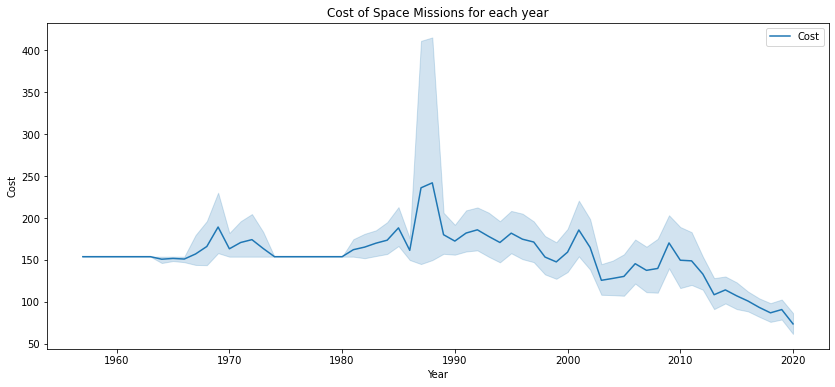

In [19]:
plt.figure(figsize = (14, 6))
plt.title('Cost of Space Missions for each year')
sns.lineplot(x = space_data['Year'], y = space_data['Cost'], label = 'Cost')
plt.savefig('Cost_of_Space_Missions_for_each_year.png')

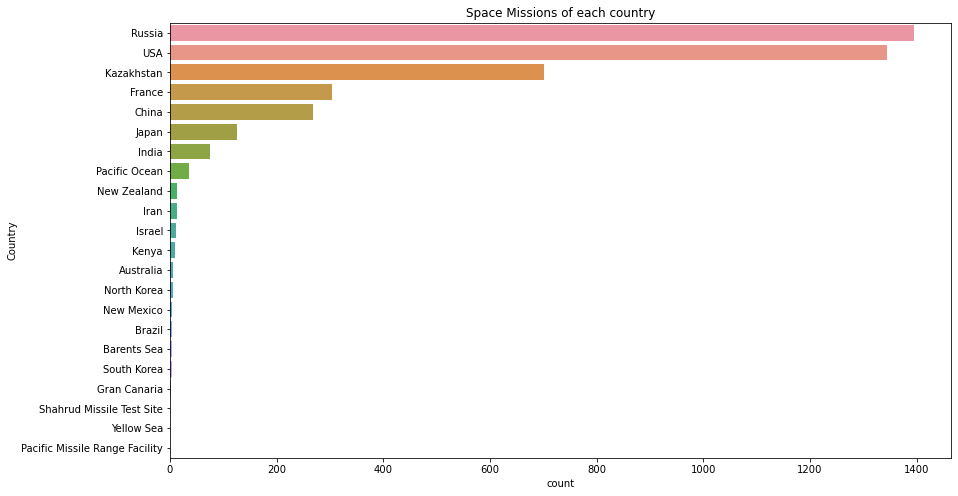

In [20]:
plt.figure(figsize = (14, 8))
plt.title('Space Missions of each country')
plt.xlabel('Amount of Space Missions')
sns.countplot(y = 'Country', data = space_data, order = space_data['Country'].value_counts().index);
plt.savefig('Space_Missions_of_each_country.png')

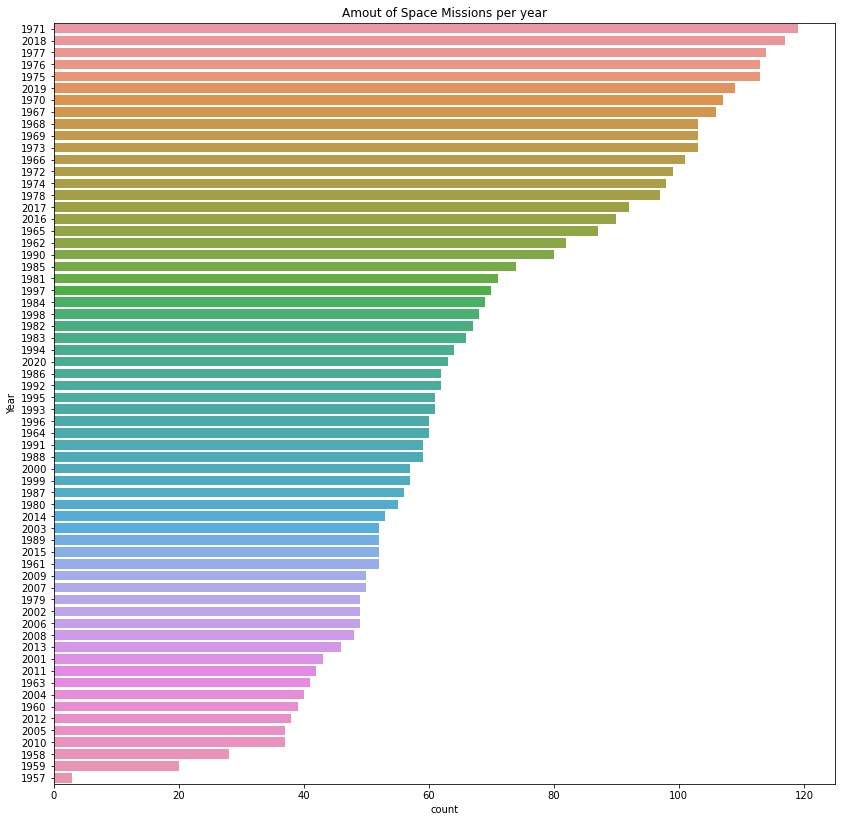

In [21]:
plt.figure(figsize = (14, 14))
plt.title('Amout of Space Missions per year')
plt.xlabel('Amount of Space Missions')
sns.countplot(y = 'Year', data = space_data, order = space_data['Year'].value_counts().index);
plt.savefig('Amout_of_Space_Missions_per_year.png')

<Figure size 432x288 with 0 Axes>

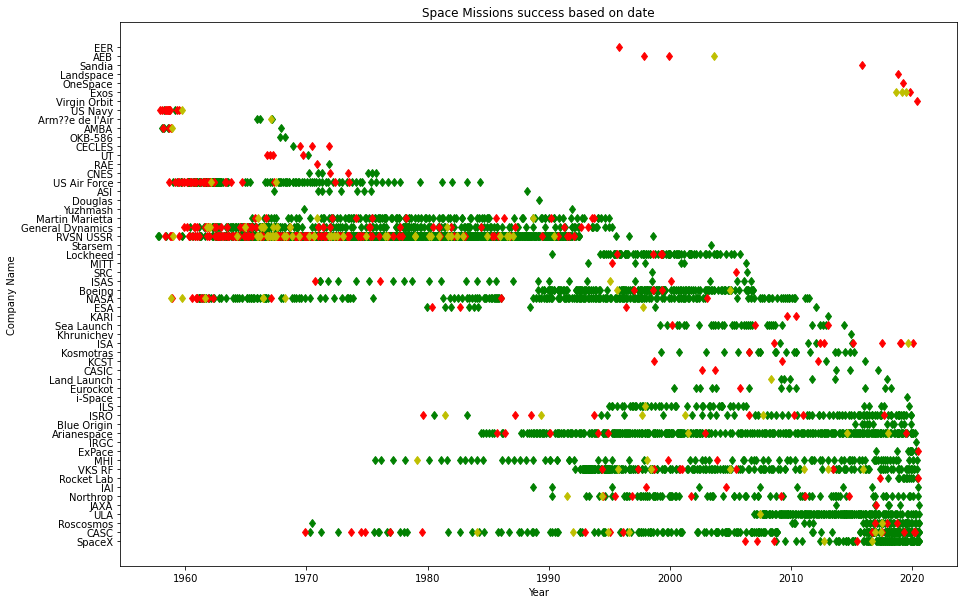

In [22]:
status_s = space_data['Mission Status'] == 'Success'
status_f = space_data['Mission Status'] == 'Failure'
status_prf = space_data['Mission Status'] == 'Prelaunch Failure'
status_pf = space_data['Mission Status'] == 'Partial Failure'
plt.figure()
plt.subplots(figsize = (15, 10))
plt.plot(space_data['Date'][status_s], space_data['Company Name'][status_s], 'gd', space_data['Date'][status_f], space_data['Company Name'][status_f], 'rd', space_data['Date'][status_prf|status_pf], space_data['Company Name'][status_prf|status_pf],'yd')
plt.title('Space Missions success based on date')
plt.xlabel('Year')
plt.ylabel('Company Name')
plt.savefig('Space_Missions_success_based_on_date.png')

D:\Programms\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
D:\Programms\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
D:\Programms\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


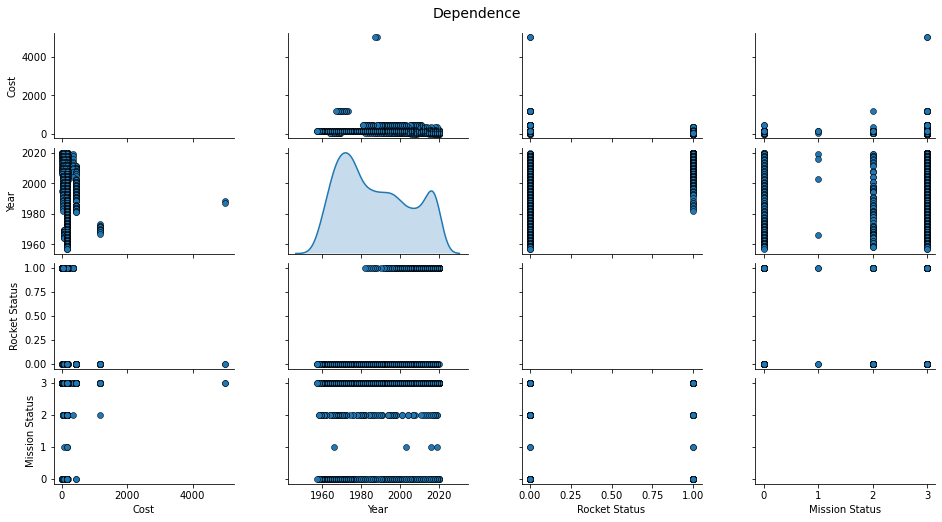

In [23]:
for i in range(len(space_data)):
    if space_data.at[i, 'Mission Status'] == 'Success':
        space_data.at[i, 'Mission Status'] = 3
    if space_data.at[i, 'Mission Status'] == 'Partial Failure':
        space_data.at[i, 'Mission Status'] = 2
    if space_data.at[i, 'Mission Status'] == 'Prelaunch Failure':
        space_data.at[i, 'Mission Status'] = 1
    if space_data.at[i, 'Mission Status'] == 'Failure':
        space_data.at[i, 'Mission Status'] = 0

cols = ['Cost', 'Year', 'Rocket Status', 'Mission Status']
pp = sns.pairplot(space_data[cols], height = 1.8, aspect = 1.8,
                  plot_kws = dict(edgecolor = "k", linewidth = 0.5),
                  diag_kind = "kde", diag_kws = dict(shade = True))

fig = pp.fig 
fig.subplots_adjust(top = 0.93, wspace = 0.3)
t = fig.suptitle('Dependence', fontsize = 14)
plt.savefig('Dependence.png')

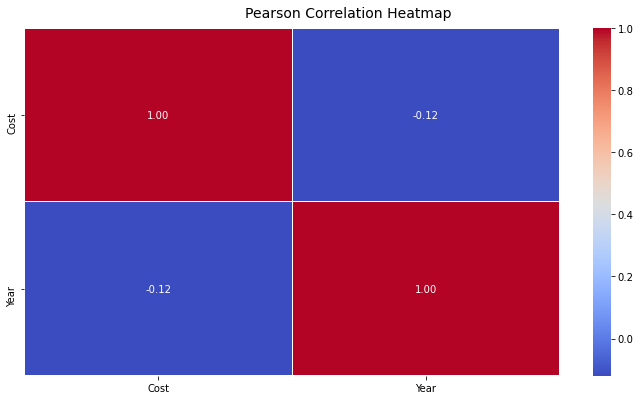

In [24]:
f, ax = plt.subplots(figsize = (12, 6))
corr = space_data.corr(method = 'pearson')
hm = sns.heatmap(round(corr, 2), annot = True, ax = ax, cmap = 'coolwarm', fmt = '.2f', linewidths = 0.025)
f.subplots_adjust(top = 0.93)
t = f.suptitle('Pearson Correlation Heatmap', fontsize = 14)
plt.savefig('Pearson_Correlation_Heatmap.png')

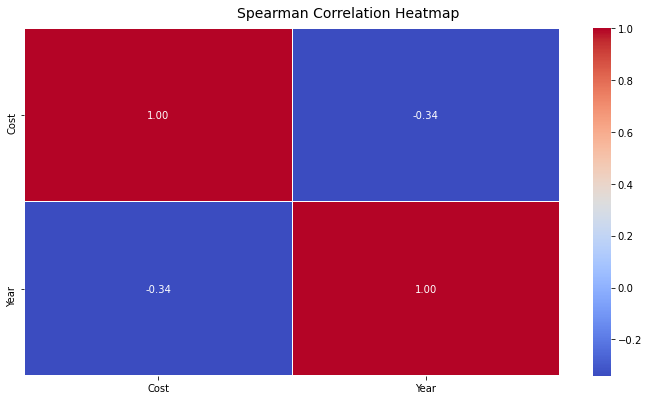

In [25]:
f, ax = plt.subplots(figsize = (12, 6))
corr = space_data.corr(method = 'spearman')
hm = sns.heatmap(round(corr, 2), annot = True, ax = ax, cmap = 'coolwarm', fmt = '.2f', linewidths = 0.025)
f.subplots_adjust(top = 0.93)
t = f.suptitle('Spearman Correlation Heatmap', fontsize = 14)
plt.savefig('Spearman_Correlation_Heatmap.png')

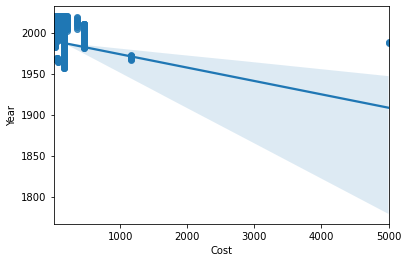

In [26]:
ax = sns.regplot(x = 'Cost', y = 'Year', data = space_data)